## Segmentation of User Interaction Logs using Time Series Methods

A demo case used for the idea paper at CAISE 2025

In [1]:
import sys

import pandas as pd
import numpy as np
import stumpy
from stumpy import config

from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder

import util.util

import matplotlib.pyplot as plt
import pm4py

import random

import time

#### Data Gathering

Gathering of the original Leno data from https://figshare.com/articles/dataset/UI_logs/12543587

In [2]:
file_path = 'Leno/'
srrt_plus_filename = "SR_RT_joint.csv"
srrt_parallel_filename = "SR_RT_parallel.csv"

text_encoding_method = "utf-8"
seperator = ";"

#### Execution of Log Generation for Discovery

Generating two extended logs
1. Adding a case id for all existing cases
2. Adding 50 random actions between all cases to simulate long time recording

In [3]:
def add_caseid_column(df: pd.DataFrame, random_insert: bool = True, num_rows: int = 50) -> pd.DataFrame:
    """
    Adds a 'caseid' column to the DataFrame, incrementing the case ID after every `num_rows` rows or at random points if `random_insert` is True.
    """
    target_url: str = "https://forms.zoho.com/universityofmelbourne/form/NewRecord/thankyou"
    target_event: str = "createNewTab"
    caseid: int = 1
    caseid_list: list[int] = []
    
    if "caseid" in df.columns:
        df = df.drop(columns=["caseid"])

    for index, row in df.iterrows():
        caseid_list.append(caseid)
        if row["url"] == target_url or ("eventType" in df.columns and row["eventType"] == target_event):
            caseid += 1
    
    df.insert(0, "caseid", caseid_list)
    
    if random_insert:
        return insert_random_rows(df, num_rows=num_rows)
    else:
        return df

def insert_random_rows(df: pd.DataFrame, num_rows: int) -> pd.DataFrame:
    """
    Inserts "num_rows" random rows at each caseid transition point.
    """
    new_df_parts: list[pd.DataFrame] = []
    prev_caseid = df.iloc[0]["caseid"]
    
    for i in range(len(df)):
        if i > 0 and df.iloc[i]["caseid"] != prev_caseid:
            new_df_parts.extend(generate_random_rows(df, num_rows))
        new_df_parts.append(pd.DataFrame([df.iloc[i]]))
        prev_caseid = df.iloc[i]["caseid"]
    
    return pd.concat(new_df_parts, ignore_index=True)

def generate_random_rows(df: pd.DataFrame, num_rows: int) -> list[pd.DataFrame]:
    """
    Generates a list of random rows from existing DataFrame values, and adds random data for URL,
    content, and target.workbookName columns.
    """
    shuffled_rows: list[pd.DataFrame] = []
    columns_to_shuffle = [col for col in df.columns if col != "caseid"]
    
    # Predefined lists for random data
    random_actions = [
    "doubleClick", "drag", "closeWindow", "scroll", "click", "hover", "resize", "select", 
    "submit", "download", "upload", "edit", "view", "delete", "create", "open", "logIn", 
    "logOut", "search", "refresh", "approve", "reject"
    ]

    random_urls = [
        "https://example.com", "https://example.org", "https://example.net", "", " ", 
        "https://randomsite.com", "https://testsite.com", "https://anotherurl.com", 
        "https://sap.example.com", "https://service-now.example.com", "https://salesforce.example.com", 
        "https://jira.example.com", "https://confluence.example.com", "https://microsoft.com", 
        "https://office365.example.com", "https://slack.com", "https://zoom.us", 
        "https://google.com", "https://github.com", "https://linkedin.com", 
        "https://workday.example.com", "https://oracle.com", "https://adobe.com"
    ]
    random_content = [
        "Lorem ipsum dolor sit amet.", "This is a random content example.", 
        "Random text for data generation.", "", " "
    ]
    random_file_names = [
        "report_final.xlsx", "data_analysis.csv", "project_notes.pdf", "", " "
    ]
    
    for _ in range(num_rows):
        # Shuffle other columns' values
        random_row: dict = {col: random.choice(df[col].tolist()) for col in columns_to_shuffle}
        
        # Add random values for specific columns
        random_row["eventType"] = random.choice(random_actions)  # Random URL
        random_row["url"] = random.choice(random_urls)  # Random URL
        random_row["content"] = random.choice(random_content)  # Random personal content
        random_row["target.workbookName"] = random.choice(random_file_names)  # Random file name
        
        shuffled_rows.append(pd.DataFrame([random_row])) 
                                            
    return shuffled_rows


# Ensure the DataFrames are empty before adding data
srrt_plus_log = pd.DataFrame()  
# srrt_parallel_log = pd.DataFrame()

# Read the original CSV Logs from Leno et al
srrt_plus_log = pd.read_csv(file_path + srrt_plus_filename, encoding=text_encoding_method, sep=seperator)
srrt_parallel_log = pd.read_csv(file_path + srrt_parallel_filename, encoding=text_encoding_method, sep=seperator)

# Add Caseids for discovery and random noise
srrt_plus_log = add_caseid_column(srrt_plus_log,random_insert=True,num_rows=50)
srrt_parallel_log = add_caseid_column(srrt_parallel_log,random_insert=True,num_rows=50)
#print(srrt_plus_log)

# Storing Files
full_path_srrt_plus = file_path + "extended_" + srrt_plus_filename
full_path_srrt_parallel = file_path + "extended_" + srrt_parallel_filename
srrt_plus_log.to_csv(full_path_srrt_plus, index=False) 
#srrt_parallel_log.to_csv(full_path_srrt_parallel, index=False) 

In [4]:
print(len(srrt_plus_log))
print(len(srrt_parallel_log))

9594
9594


# Setup of Notebook

Please select the log you want to process in the following boxes

The following box automatically gathers the ground truth based on the arteficially inserted data.

In [5]:
log_to_discover = srrt_plus_log
#log_to_discover = srrt_parallel_log

# ---- Generate Ground Truth ----
def generate_caseid_list(df: pd.DataFrame) -> list[int]:
    """
    Generates a list of tuples where each tuple contains a caseid and the row index where that caseid is first encountered.
    """
    caseid_list_with_indices = []
    seen_caseids = set()  # To keep track of the caseid values we've already encountered
    
    for index, caseid in df['caseid'].items():
        if pd.notna(caseid) and caseid not in seen_caseids:
            caseid_list_with_indices.append(index)
            seen_caseids.add(caseid)  # Add caseid to the set to track it
    
    return caseid_list_with_indices

groundTruth = generate_caseid_list(log_to_discover)

## 1. Hot Encoding Method(s)

Based on the context columns the discovery will be executed

In [71]:
log_to_discover = srrt_plus_log
#log_to_discover = srrt_parallel_log

# ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id"] # Leno Attributes
ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]

size = 25
NumberOfMotifsToDiscover = 25

# ---- Reading the File ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])
uiLog_Encoding_method = 3 # 1=Hierarchy Encoding, 2=Co-Occurrance Encoding, 3=Hot Encoding

uiLog = util.util.encoding_UiLog(log_to_discover,orderedColumnsList=ContextColumns,encoding=uiLog_Encoding_method)

# ---- Time Series Mining ----
tm_matrix, event_series = util.util.discover_motifs(uiLog, window_size=size, normalize=True)

print(f"event_series shape: {event_series.shape}")
print(f"tm_matrix shape: {tm_matrix.shape}")
print(f"tm_matrix[:,0] shape: {tm_matrix[:,0].shape}")

# The motifs have to be exclusive, thus, no one activity must be part of a routine already discovered
config.STUMPY_EXCL_ZONE_DENOM = 1  # The exclusion zone is i ± m
top_motifs = stumpy.motifs(T=event_series, P=tm_matrix[:,0], min_neighbors=1, max_matches=NumberOfMotifsToDiscover, cutoff=5)
# Identify the outlier
discord_idx = np.argsort(tm_matrix[:, 0])[-1]
print(f"Discovered: {np.sort(top_motifs[1][0])}")

event_series shape: (9594,)
tm_matrix shape: (9570, 4)
tm_matrix[:,0] shape: (9570,)
Discovered: [   6   32  110  136  189  215  270  296  351  377  432  458  511  537
  593  673  699  754  780  835  861  914  940  995 1021]


In [ ]:
print(f"Ground Truth:{np.sort(groundTruth)}")

# For 1-dim time series
insert_spots, motif_spots, overlapDF = util.util.compare_sets(set(groundTruth), set(top_motifs[1][0]), (size/2))

ground_truth_sum = len(groundTruth)
true_positives = len(insert_spots)
false_positives = NumberOfMotifsToDiscover - true_positives  # Incorrectly identified motifs
false_negatives = ground_truth_sum - true_positives  # Relevant motifs not identified

# Precision
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
print(f"Precision: {precision}")

# Recall
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
print(f"Recall: {recall}")

# F1-Score
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1-Score: {f1_score}")

## 2. Word2Vec Encoding

Single Sentence Word2Vec encoding

> Im Paper Änderungen
1. Methodenbeschreibung anpassen > Word2Vec
2. A reduced set of parameters provides better results as described in Matrix Profil 4 paper, 
    a Method to identify the best set of parameters for mining the data has to be developed.
2. Multi-Dimensionale Motif discovery
3. Experiment mit dieser Encoding method durchführen und ergebnisskurve auswerten

In [28]:
# Example execution using encoding == 5 convention
columns_to_use = ['eventType', 'targetApp', 'target.tagName', 'target.name']
#columns_to_use = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]
ui_log_encoded_w2v = util.util.encode_word2vec(srrt_plus_log, orderedColumnsList=columns_to_use)
window_size = 30
motifs_to_discover = 50
motif_distances, motif_indices, motif_subspaces, motif_mdls = util.util.mine_w2v(ui_log_encoded_w2v,window_size,motifs_to_discover)
motif_indices

array([[ 240,   80,  321,  402,  643,  724,  805,  965, 1046, 1209, 1609,
        1772, 1853, 2092, 2173, 2254, 2335, 2498, 2579, 2660, 2741, 2904,
        2985, 3066, 3228, 3309, 3390, 3471, 3552, 3633, 3714, 3795, 3876,
        2823, 3957, 3147,  562, 1369, 1127,  886,  161, 1290, 1530, 1934,
           1,  483, 2013, 1451, 1691, 2417]], dtype=int64)

#### Quality Measures

In [ ]:
print(f"Ground Truth:{np.sort(groundTruth)}")

# For word2vec time series
# insert_spots, motif_spots, overlapDF = util.util.compare_sets(set(groundTruth), set(motif_indices[0]), (size/2))
insert_spots, motif_spots, overlapDF = util.util.compare_sets_IoU(set(groundTruth), set(motif_indices[0]), window_size, iou_threshold=0.7)

ground_truth_sum = len(groundTruth)
true_positives = len(insert_spots)
false_positives = motifs_to_discover - true_positives  # Incorrectly identified motifs
false_negatives = ground_truth_sum - true_positives  # Relevant motifs not identified

# Precision
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
print(f"Precision: {precision}")

# Recall
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
print(f"Recall: {recall}")

# F1-Score
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1-Score: {f1_score}")

Ground Truth:[   0   79  160  239  320  401  482  561  643  723  804  885  964 1045
 1126 1208 1289 1368 1451 1530 1608 1689 1771 1852 1933 2012 2091 2172
 2253 2334 2415 2497 2578 2659 2740 2821 2903 2984 3065 3146 3227 3308
 3389 3470 3551 3632 3713 3794 3875 3956 4037 4148 4260 4372 4484 4596
 4708 4821 4933 5045 5157 5269 5381 5493 5605 5717 5832 5944 6056 6168
 6282 6394 6506 6618 6730 6842 6954 7066 7178 7290 7404 7516 7628 7740
 7852 7964 8076 8188 8300 8412 8524 8636 8749 8861 8973 9085 9198 9310
 9422 9534]
0.9357258064516129
Precision: 1.0
Recall: 0.5
F1-Score: 0.6666666666666666


c:\Users\tomho\OneDrive\Documents\VSCode\TimeSeriesInRPM\util\util.py:854: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  set_matches = set_matches._append(dict1, ignore_index=True)


## 3. Automated Experiment for multiple window sizes

### A. Hot Encoding Based Multi Window Experiment

The following code tests multiple window sizes againts the encoding method and number of motifs to be discovered and visualizes the F1-Score trend afterwards.

In [ ]:
# ---- Inputs ----
log_to_discover = srrt_plus_log
# log_to_discover = srrt_parallel_log

ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]
ContextColumns = ['eventType', 'targetApp', 'target.tagName', 'target.name']


NumberOfMotifsToDiscover = 10
uiLog_Encoding_method = 3  # 1=Hierarchy Encoding, 2=Co-Occurrance Encoding, 3=Hot Encoding

# ---- Clean log ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])

uiLog = util.util.encoding_UiLog(log_to_discover, orderedColumnsList=ContextColumns, encoding=uiLog_Encoding_method)

# ---- Ground Truth ----
def generate_caseid_list(df: pd.DataFrame) -> list[int]:
    caseid_list_with_indices = []
    seen_caseids = set()
    for index, caseid in df['caseid'].items():
        if pd.notna(caseid) and caseid not in seen_caseids:
            caseid_list_with_indices.append(index)
            seen_caseids.add(caseid)
    return caseid_list_with_indices

groundTruth = generate_caseid_list(log_to_discover)
groundTruth_set = set(groundTruth)
ground_truth_sum = len(groundTruth)

# ---- Results container ----
results = []

# ---- Main loop ----
for size in range(25, 66):
    uiLog = util.util.encoding_UiLog(log_to_discover, orderedColumnsList=ContextColumns, encoding=uiLog_Encoding_method)
    tm_matrix, event_series = util.util.discover_motifs(uiLog, window_size=size, normalize=True)
    
    config.STUMPY_EXCL_ZONE_DENOM = 1
    top_motifs = stumpy.motifs(T=event_series, P=tm_matrix[:, 0], min_neighbors=1, max_matches=NumberOfMotifsToDiscover, cutoff=5)
    
    discovered_set = set(top_motifs[1][0])
    insert_spots, motif_spots, overlapDF = util.util.compare_sets(groundTruth_set, discovered_set, (size/2))
    # insert_spots, motif_spots, overlapDF = util.util.compare_sets_IoU(groundTruth_set, discovered_set, window_size=size, iou_threshold=0.5)

    true_positives = len(insert_spots)
    false_positives = NumberOfMotifsToDiscover - true_positives
    false_negatives = ground_truth_sum - true_positives
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    results.append({
        'window_size': size,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    })

    # print("Execution completed for window size:" + str(size))

# ---- Save the results ----
results_df = pd.DataFrame(results)
results_df.to_csv('motif_discovery_window_size_experiment.csv', index=False)
# print(results_df)

# ---- Plot F1-Score vs Window Size ----
plt.figure(figsize=(10, 6))
plt.plot(results_df['window_size'], results_df['f1_score'], marker='o', linewidth=2)

plt.title('Effect of Window Size on F1-Score', fontsize=16)
plt.xlabel('Window Size', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(results_df['window_size'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### B. Word2Vec Encoding Based

Iterates in the range of window size 25 to 66 over the time series encoded by with word2vec.

Can consider windowsize/2 or IoU threshold as quality value for measuring.


In [ ]:
# ---- Inputs ----
log_to_discover = srrt_plus_log
# log_to_discover = srrt_parallel_log

ContextColumns = ["targetApp","eventType","url","target.workbookName","target.sheetName","target.id","target.class","target.tagName","target.type","target.name","target.innerText","target.checked","target.href","target.option","target.title","target.innerHTML"]
ContextColumns = ['eventType', 'targetApp', 'target.tagName', 'target.name']


NumberOfMotifsToDiscover = 10
uiLog_Encoding_method = 3  # 1=Hierarchy Encoding, 2=Co-Occurrance Encoding, 3=Hot Encoding

# ---- Clean log ----
if "tuple:id" in log_to_discover.columns:
    log_to_discover = log_to_discover.drop(columns=["tuple:id"])

ui_log_encoded_w2v = util.util.encode_word2vec(srrt_plus_log, orderedColumnsList=ContextColumns)

# ---- Ground Truth ----
def generate_caseid_list(df: pd.DataFrame) -> list[int]:
    caseid_list_with_indices = []
    seen_caseids = set()
    for index, caseid in df['caseid'].items():
        if pd.notna(caseid) and caseid not in seen_caseids:
            caseid_list_with_indices.append(index)
            seen_caseids.add(caseid)
    return caseid_list_with_indices

groundTruth = generate_caseid_list(log_to_discover)
groundTruth_set = set(groundTruth)
ground_truth_sum = len(groundTruth)

# ---- Results container ----
results = []

# ---- Main loop ----
for size in range(25, 66):
    motif_distances, motif_indices, motif_subspaces, motif_mdls = util.util.mine_w2v(ui_log_encoded_w2v,size,NumberOfMotifsToDiscover)

    discovered_set = set(motif_indices[0])
    # insert_spots, motif_spots, overlapDF = util.util.compare_sets(groundTruth_set, discovered_set, (size/2))
    insert_spots, motif_spots, overlapDF = util.util.compare_sets_IoU(groundTruth_set, discovered_set, window_size=size, iou_threshold=0.5)

    if 'IoU' in overlapDF.columns:
        mean_iou = overlapDF.loc[:, "IoU"].mean()
    else:
        mean_iou = -1

    true_positives = len(insert_spots)
    false_positives = NumberOfMotifsToDiscover - true_positives
    false_negatives = ground_truth_sum - true_positives
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    
    print(f"Loop {size} completed. Results appending. F1-Score: {f1_score}")
    results.append({
        'window_size': size,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mean_iou': mean_iou,
        'discovered_indexes': motif_indices
    })

    # print("Execution completed for window size:" + str(size))

# ---- Save the results ----
results_df = pd.DataFrame(results)
results_df.to_csv('ExperimentResult/w2v_iuo_motif_discovery_experiment.csv', index=False)
# print(results_df)

Loop 25 completed. Results appending. F1-Score: 0.18181818181818182
Loop 26 completed. Results appending. F1-Score: 0.18181818181818182
Loop 27 completed. Results appending. F1-Score: 0.18181818181818182
Loop 28 completed. Results appending. F1-Score: 0.18181818181818182
Loop 29 completed. Results appending. F1-Score: 0.18181818181818182
Loop 30 completed. Results appending. F1-Score: 0.18181818181818182
Loop 31 completed. Results appending. F1-Score: 0.18181818181818182
Loop 32 completed. Results appending. F1-Score: 0.18181818181818182
Loop 33 completed. Results appending. F1-Score: 0.18181818181818182
Loop 34 completed. Results appending. F1-Score: 0.18181818181818182
Loop 35 completed. Results appending. F1-Score: 0.18181818181818182
Loop 36 completed. Results appending. F1-Score: 0.18181818181818182
Loop 37 completed. Results appending. F1-Score: 0.18181818181818182
Loop 38 completed. Results appending. F1-Score: 0.18181818181818182
Loop 39 completed. Results appending. F1-Score: 

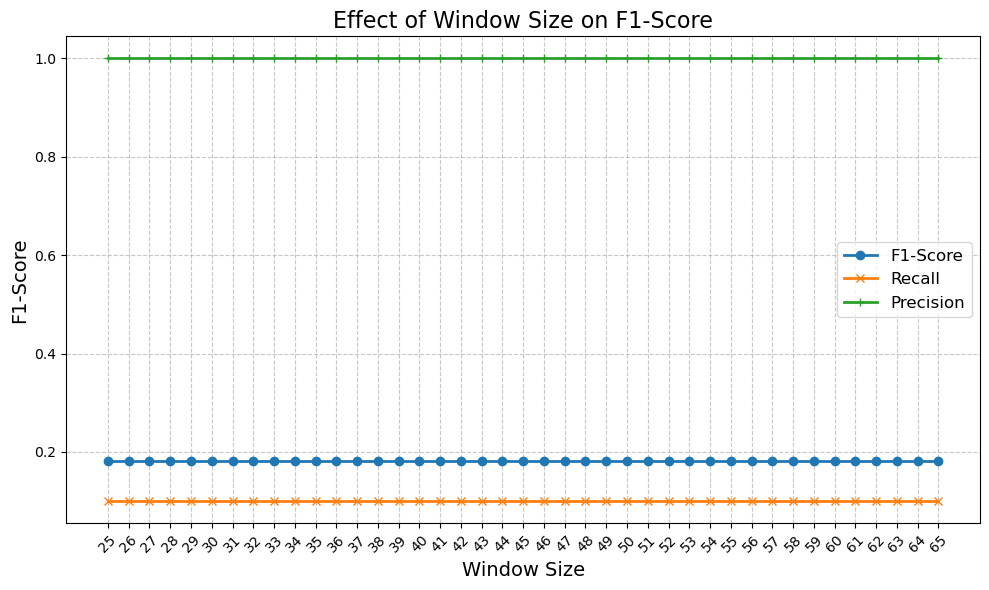

In [87]:
# ---- Plot F1-Score vs Window Size ----
plt.figure(figsize=(10, 6))
plt.plot(results_df['window_size'], results_df['f1_score'], marker='o', linewidth=2, label='F1-Score')
plt.plot(results_df['window_size'], results_df['recall'], marker='x', linewidth=2, label='Recall')
plt.plot(results_df['window_size'], results_df['precision'], marker='+', linewidth=2, label='Precision')

plt.title('Effect of Window Size on F1-Score', fontsize=16)
plt.xlabel('Window Size', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(results_df['window_size'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(fontsize=12)
plt.show()

#### Visualisation

In [ ]:
# ---- DFG Mining ----
caseuiLog = util.util.reduceLogToDiscovered(uiLog,top_motifs[1][0],size)
end_time = time.time()

cols = ["targetApp","eventType"]
caseuiLog["concept:name"] = caseuiLog[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
caseuiLog["time:timestamp"] = caseuiLog["timeStamp"]
caseuiLog['case:concept:name'] = caseuiLog['case:concept:name'].astype('int64')
pm4pyDf = pm4py.format_dataframe(caseuiLog)
uiLogDFG, start_activities, end_activities = pm4py.discover_dfg(pm4pyDf)
pm4py.view_dfg(uiLogDFG, start_activities, end_activities)

# ---- Motif Visualisation ----
starting_row = 0
ending_row = len(uiLog)-1
ids = uiLog.loc[starting_row:ending_row,'tuple:id'].tolist()
rows = [i for i in range(len(uiLog.loc[starting_row:ending_row,'tuple:id']))]

#Plot Event data
fig2, axs2 = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Routine) Discovery', fontsize='10')

axs2[0].scatter(rows, ids, alpha=0.8)
axs2[0].set_ylabel('Events', fontsize='10')
# Plot Timeseries data
axs2[1].plot(event_series)
axs2[1].set_ylabel('Timeseries', fontsize='10')
# Plot Matrix profiles
axs2[2].set_xlabel('Activity', fontsize ='10')
axs2[2].set_ylabel('Matrix Profile', fontsize='10')
axs2[2].set_ylim(top=tm_matrix[:, 0].max()*1.1) #displaying the max value with some uplift for space in Graph
axs2[2].plot(tm_matrix[:, 0])
# Adding Dashed lines
for discovered in top_motifs[1][0]:
    axs2[0].axvline(x=discovered, linestyle="dashed",color='C1')
    #axs2[1].axvline(x=discovered, linestyle="dashed",color='C1')
    axs2[2].axvline(x=discovered, linestyle="dashed",color='C1')

# Display Pattern overlay
fig, ax = plt.subplots(figsize=(6.5, 2))
plt.title('Motif Overlay', fontsize='10')
ax.set_xlabel("Events", fontsize='10')
ax.set_ylabel("Timeseries", fontsize='10')
# Plot motif and nearest neighbor window
for i, val in enumerate(top_motifs[1][0]):
    colorPlot = 'C' + str(i)
    ax.plot(event_series[val:val+size], color=colorPlot, label=f"Motif {i}")
    
plt.legend(loc="best",fontsize=10)
plt.show()